# Problem 1

Consider a 2D robotic arm with 3 links. The position of its end-effector is governed by the arm lengths and joint angles as follows (as in the figure "data/robot-arm.png"):
$$
x = L_1 \cos(\theta_1) + L_2\cos(\theta_2+\theta_1) + L_3\cos(\theta_3+\theta_2+\theta_1)\\
y = L_1\sin(\theta_1) + L_2\sin(\theta_2+\theta_1) + L_3\sin(\theta_3+\theta_2+\theta_1)
$$

In robotics settings, inverse-kinematics problems are common for setups like this. For example, suppose all 3 arm lengths are $L_1 = L_2 = L_3 = 1$, and we want to position the end-effector at $(x,y) = (0.5, 0.5)$. What set of joint angles $(\theta_1, \theta_2, \theta_3)$ should we choose for the end-effector to reach this position?

In this problem you will train a neural network to find a function mapping from coordinates $(x,y)$ to joint angles $(\theta_1, \theta_2, \theta_3)$ that position the end-effector at $(x,y)$.



#### Summary of deliverables:

1. Neural network model

2. Generate training and validation data

3. Training function

4. 6 plots with training and validation loss

5. 6 prediction plots

6. Respond to the prompts


In [60]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

class ForwardArm(nn.Module):
    def __init__(self, L1=1, L2=1, L3=1):
        super().__init__()
        self.L1 = L1
        self.L2 = L2
        self.L3 = L3
    def forward(self, angles):
        theta1 = angles[:,0]
        theta2 = angles[:,1]
        theta3 = angles[:,2]
        x = self.L1*torch.cos(theta1) + self.L2*torch.cos(theta1+theta2) + self.L3*torch.cos(theta1+theta2+theta3)
        y = self.L1*torch.sin(theta1) + self.L2*torch.sin(theta1+theta2) + self.L3*torch.sin(theta1+theta2+theta3)
        return torch.vstack([x,y]).T

def plot_predictions(model, title=""):
    fwd = ForwardArm()

    vals = np.arange(0.1, 2.0, 0.2)
    x, y = np.meshgrid(vals,vals)
    coords = torch.tensor(np.vstack([x.flatten(),y.flatten()]).T,dtype=torch.float)
    angles = model(coords)
    preds = fwd(angles).detach().numpy()

    plt.figure(figsize=[4,4],dpi=140)

    plt.scatter(x.flatten(), y.flatten(), s=60, c="None",marker="o",edgecolors="k", label="Targets")
    plt.scatter(preds[:,0], preds[:,1], s=25, c="red", marker="o", label="Predictions")
    plt.text(0.1, 2.15, f"MSE = {nn.MSELoss()(fwd(model(coords)),coords):.1e}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-.1,2.1)
    plt.ylim(-.1,2.4)
    plt.legend()
    plt.title(title)
    plt.show()

def plot_arm(theta1, theta2, theta3, L1=1,L2=1,L3=1, show=True):
    x1 = L1*np.cos(theta1)
    y1 = L1*np.sin(theta1)
    x2 = x1 + L2*np.cos(theta1+theta2)
    y2 = y1 + L2*np.sin(theta1+theta2)
    x3 = x2 + L3*np.cos(theta1+theta2+theta3)
    y3 = y2 + L3*np.sin(theta1+theta2+theta3)
    xs = np.array([0,x1,x2,x3])
    ys = np.array([0,y1,y2,y3])

    plt.figure(figsize=(5,5),dpi=140)
    plt.plot(xs, ys, linewidth=3, markersize=5,color="gray", markerfacecolor="lightgray",marker="o",markeredgecolor="black")
    plt.scatter(x3,y3,s=50,color="blue",marker="P",zorder=100)
    plt.scatter(0,0,s=50,color="black",marker="s",zorder=-100)
    
    plt.xlim(-1.5,3.5)
    plt.ylim(-1.5,3.5)

    if show:
        plt.show()

## End-effector position

You can use the interactive figure below to visualize the robot arm.

In [61]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown

def plot_unit_arm(theta1, theta2, theta3):
    plot_arm(theta1, theta2, theta3)

slider1 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta1',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider2 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta2',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider3 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta3',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))

interactive_plot = interactive(plot_unit_arm, theta1 = slider1, theta2 = slider2, theta3 = slider3)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=0.0, description='theta1', layout=Layout(width='550px'), max=2.3561944…

## Neural Network for Inverse Kinematics
In this class we have mainly had regression problems with only one output. However, you can create neural networks with any number of outputs just by changing the size of the last layer. For this problem, we already know the function to go from joint angles (3) to end-effector coordinates (2). This is provided in neural network format as `ForwardArm()`.

If you provide an instance of `ForwardArm()` with an $N\times3$ tensor of joint angles, and it will return an $N\times2$ tensor of coordinates.

Here, you should create a neural network with 2 inputs and 3 outputs that, once trained, can output the joint angles (in radians) necessary to reach the input x-y coordinates.

In the cell below, complete the definition for `InverseArm()`:
- The initialization argument `hidden_layer_sizes` dictates the number of neurons per hidden layer in the network. For example, `hidden_layer_sizes=[12,24]` should create a network with 2 inputs, 12 neurons in the first hidden layer, 24 neurons in the second hidden layer, and 3 outputs.
- Use a ReLU activation at the end of each hidden layer.
- The initialization argument `max_angle` refers to the maximum bend angle of the joint. If `max_angle=None`, there should be no activation at the last layer. However, if `max_angle=1` (for example), then the output joint angles should be restricted to the interval [-1, 1] (radians). You can clamp values with the tanh function (and then scale them) to achieve this.



In [62]:
class InverseArm(nn.Module):
    def __init__(self, hidden_layer_sizes=[24,24], max_angle = None):
        super().__init__()
        # YOUR CODE GOES HERE
        self.max_angle = max_angle

        self.layers = nn.ModuleList()

        for i in range(len(hidden_layer_sizes)):
            self.layers.append(nn.Linear(hidden_layer_sizes[i - 1] if i > 0 else 2, hidden_layer_sizes[i]))
        self.layers.append(nn.Linear(hidden_layer_sizes[-1], 3))

    def forward(self, xy):
        # YOUR CODE GOES HERE
        angles = xy

        for layer in self.layers[:-1]:
            angles = torch.relu(layer(angles))
        angles = self.layers[-1](angles)

        if self.max_angle is not None:
            angles = torch.tanh(angles) * self.max_angle

        return angles

## Generate Data

In the cell below, generate a dataset of x-y coordinates. You should use a $100\times 100$ meshgrid, for x and y each on the interval $[0, 2]$.  

Randomly split your data so that 80% of points are in `X_train`, while the remaining 20% are in `X_val`. (Each of these should have 2 columns -- x and y)

In [63]:
# YOUR CODE GOES HERE
from sklearn.model_selection import train_test_split

x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
x_grid, y_grid = np.meshgrid(x, y)
coordinates = torch.tensor(np.vstack([x_grid.ravel(), y_grid.ravel()]).T, dtype = torch.float)

X_train, X_val = train_test_split(coordinates, test_size=0.2, random_state=42)

## Training function

Write a function `train()` below with the following specifications:

*Inputs:*  
- `model`: `InverseArm` model to train
- `X_train`: $N\times 2$ vector of training x-y coordinates
- `X_val`: $N\times 2$ vector of validation x-y coordinates
- `lr`: Learning rate for Adam optimizer
- `epochs`: Total epoch count
- `gamma`: ExponentialLR decay rate
- `create_plot`: (`True`/`False`) Whether to display a plot with training and validation loss curves

*Loss function:*  
The loss function you use should be based on whether the end-effector moves to the correct location. It should be the MSE between the target coordinate tensor and the coordinates that the predicted joint angles produce. In other words, if your inverse kinematics model is `model`, and `fwd` is an instance of `ForwardArm()`, then you want the MSE between input coordinates `X` and `fwd(model(X))`.


In [68]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model, X_train, X_val, lr = 0.01, epochs = 1000, gamma = 1, create_plot = True):
    # YOUR CODE GOES HERE
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    fwd = ForwardArm()
    lossfun = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr = lr)
    scheduler = optim.lr_scheduler.StepLR(opt, step_size = 100, gamma = gamma)

    train_hist = []
    val_hist = []

    for epoch in range(epochs):
        model.train()

        opt.zero_grad()

        angles_pred_train = model(X_train)
        coords_pred_train = fwd(angles_pred_train)

        loss_train = lossfun(coords_pred_train, X_train)
        loss_train.backward()
        
        opt.step()

        train_hist.append(loss_train.item())

        model.eval()
        with torch.no_grad():
            predicted_angles_val = model(X_val)
            predicted_coords_val = fwd(predicted_angles_val)
            loss_val = lossfun(predicted_coords_val, X_val)
            val_hist.append(loss_val.item())

        scheduler.step()

        if epoch % (epochs // 25) == 0:
                print(f"Epoch {epoch:>4}/{epochs}: Train Loss = {loss_train.item():.4f}, Validation Loss = {loss_val.item():.4f}")

    if create_plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_hist, label='Training Loss')
        plt.plot(val_hist, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    return model

## Training a model

Create 3 models of different complexities (with `max_angle=None`):
- `hidden_layer_sizes=[12]`
- `hidden_layer_sizes=[24,24]`
- `hidden_layer_sizes=[48,48,48]`

Train each model for 1000 epochs, learning rate 0.01, and gamma 0.995. Show the plot for each.

C:\Users\barat\AppData\Local\Temp\ipykernel_15088\664775586.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\barat\AppData\Local\Temp\ipykernel_15088\664775586.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


Epoch    0/1000: Train Loss = 4.8425, Validation Loss = 4.4216
Epoch   40/1000: Train Loss = 0.6166, Validation Loss = 0.6107
Epoch   80/1000: Train Loss = 0.1139, Validation Loss = 0.1108
Epoch  120/1000: Train Loss = 0.0319, Validation Loss = 0.0315
Epoch  160/1000: Train Loss = 0.0223, Validation Loss = 0.0227
Epoch  200/1000: Train Loss = 0.0185, Validation Loss = 0.0187
Epoch  240/1000: Train Loss = 0.0155, Validation Loss = 0.0156
Epoch  280/1000: Train Loss = 0.0129, Validation Loss = 0.0131
Epoch  320/1000: Train Loss = 0.0108, Validation Loss = 0.0109
Epoch  360/1000: Train Loss = 0.0091, Validation Loss = 0.0092
Epoch  400/1000: Train Loss = 0.0077, Validation Loss = 0.0077
Epoch  440/1000: Train Loss = 0.0066, Validation Loss = 0.0066
Epoch  480/1000: Train Loss = 0.0056, Validation Loss = 0.0056
Epoch  520/1000: Train Loss = 0.0048, Validation Loss = 0.0048
Epoch  560/1000: Train Loss = 0.0042, Validation Loss = 0.0042
Epoch  600/1000: Train Loss = 0.0036, Validation Loss =

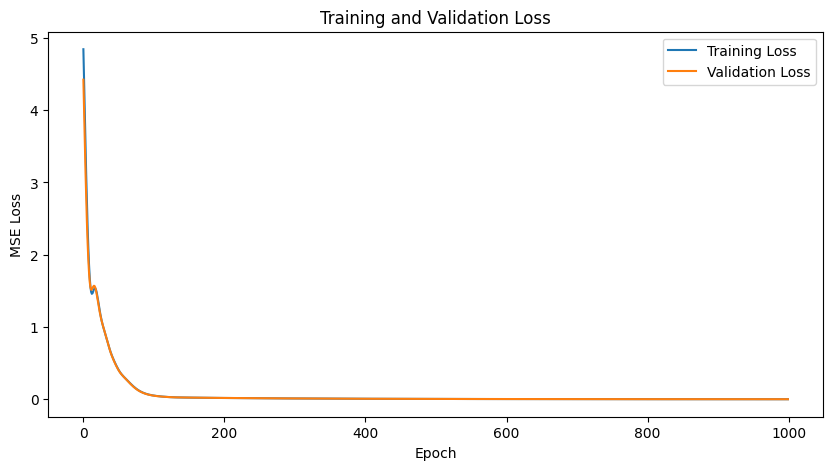

Epoch    0/1000: Train Loss = 2.6520, Validation Loss = 1.7917
Epoch   40/1000: Train Loss = 0.0806, Validation Loss = 0.0777
Epoch   80/1000: Train Loss = 0.0179, Validation Loss = 0.0185
Epoch  120/1000: Train Loss = 0.0078, Validation Loss = 0.0081
Epoch  160/1000: Train Loss = 0.0030, Validation Loss = 0.0032
Epoch  200/1000: Train Loss = 0.0017, Validation Loss = 0.0017
Epoch  240/1000: Train Loss = 0.0012, Validation Loss = 0.0013
Epoch  280/1000: Train Loss = 0.0009, Validation Loss = 0.0010
Epoch  320/1000: Train Loss = 0.0008, Validation Loss = 0.0008
Epoch  360/1000: Train Loss = 0.0007, Validation Loss = 0.0007
Epoch  400/1000: Train Loss = 0.0007, Validation Loss = 0.0007
Epoch  440/1000: Train Loss = 0.0006, Validation Loss = 0.0006
Epoch  480/1000: Train Loss = 0.0006, Validation Loss = 0.0006
Epoch  520/1000: Train Loss = 0.0005, Validation Loss = 0.0005
Epoch  560/1000: Train Loss = 0.0005, Validation Loss = 0.0005
Epoch  600/1000: Train Loss = 0.0004, Validation Loss =

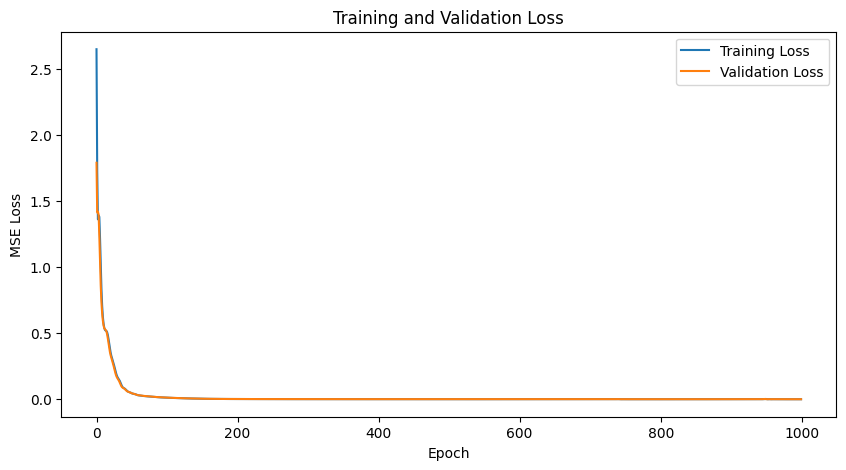

Epoch    0/1000: Train Loss = 2.6872, Validation Loss = 2.0361
Epoch   40/1000: Train Loss = 0.0297, Validation Loss = 0.0326
Epoch   80/1000: Train Loss = 0.0021, Validation Loss = 0.0020
Epoch  120/1000: Train Loss = 0.0008, Validation Loss = 0.0008
Epoch  160/1000: Train Loss = 0.0005, Validation Loss = 0.0005
Epoch  200/1000: Train Loss = 0.0003, Validation Loss = 0.0003
Epoch  240/1000: Train Loss = 0.0002, Validation Loss = 0.0002
Epoch  280/1000: Train Loss = 0.0002, Validation Loss = 0.0002
Epoch  320/1000: Train Loss = 0.0002, Validation Loss = 0.0002
Epoch  360/1000: Train Loss = 0.0001, Validation Loss = 0.0001
Epoch  400/1000: Train Loss = 0.0001, Validation Loss = 0.0001
Epoch  440/1000: Train Loss = 0.0001, Validation Loss = 0.0001
Epoch  480/1000: Train Loss = 0.0001, Validation Loss = 0.0001
Epoch  520/1000: Train Loss = 0.0001, Validation Loss = 0.0001
Epoch  560/1000: Train Loss = 0.0001, Validation Loss = 0.0001
Epoch  600/1000: Train Loss = 0.0001, Validation Loss =

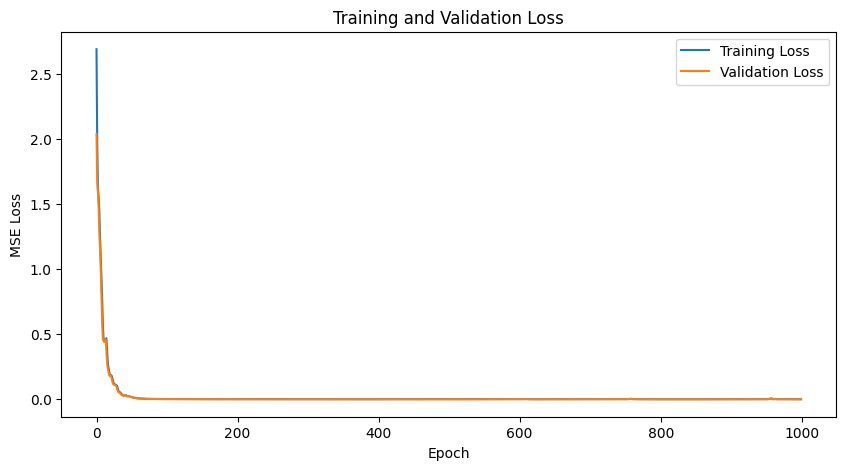

In [69]:
# YOUR CODE GOES HERE
model1 = InverseArm(hidden_layer_sizes = [12], max_angle = None)
model2 = InverseArm(hidden_layer_sizes = [24, 24], max_angle = None)
model3 = InverseArm(hidden_layer_sizes = [48, 48, 48], max_angle = None)

model1 = train(model1, X_train, X_val, epochs = 1000, lr = 0.01, gamma = 0.995, create_plot = True)
model2 = train(model2, X_train, X_val, epochs = 1000, lr = 0.01, gamma = 0.995, create_plot = True)
model3 = train(model3, X_train, X_val, epochs = 1000, lr = 0.01, gamma = 0.995, create_plot = True)

## Visualizations

For each of your models, use the function `plot_predictions` to visualize model predictions on the domain. You should observe improvements with increasing network size.

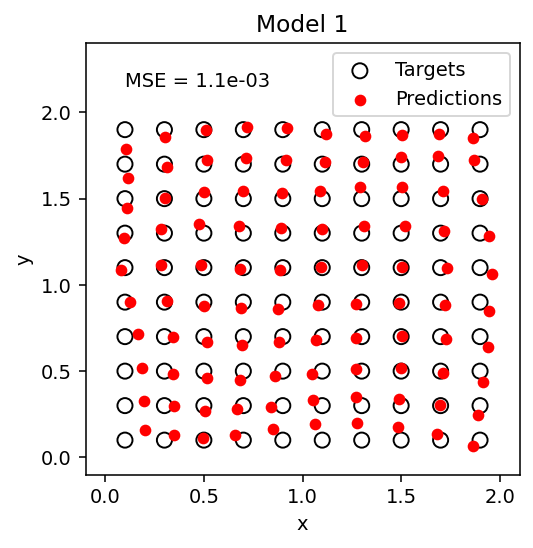

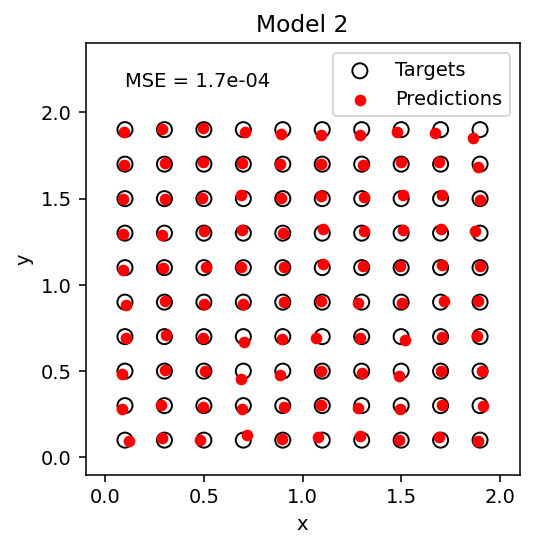

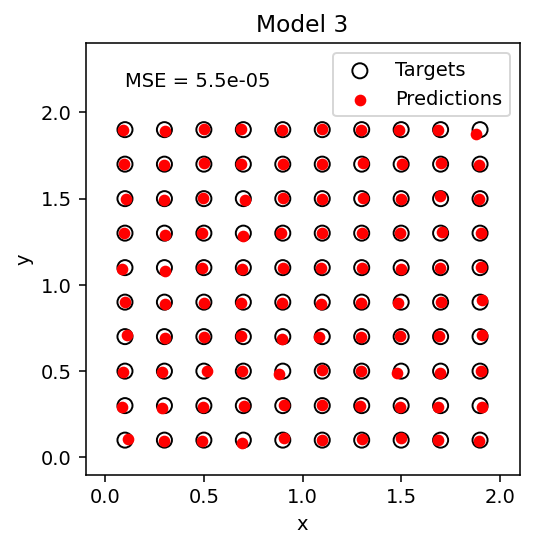

In [73]:
# YOUR CODE GOES HERE

plot_predictions(model1, title = "Model 1")
plot_predictions(model2, title = "Model 2")
plot_predictions(model3, title = "Model 3")

## Interactive Visualization


You can use the interactive plot below to look at the performance of your model. (The model used must be named `model`.)

In [72]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown

def plot_inverse(x, y):
    xy = torch.Tensor([[x,y]])
    theta1, theta2, theta3 = model1(xy).detach().numpy().flatten().tolist()
    plot_arm(theta1, theta2, theta3, show=False)
    plt.scatter(x, y, s=100, c="red",zorder=1000,marker="x")
    plt.plot([0,2,2,0,0],[0,0,2,2,0],c="lightgray",linewidth=1,zorder=-1000)
    plt.show()

slider1 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='x', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))
slider2 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='y', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))

interactive_plot = interactive(plot_inverse, x = slider1, y = slider2)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x', layout=Layout(width='550px'), max=2.5, min=-0.5,…

## Training more neural networks

Now train more networks with the following details:
1. `hidden_layer_sizes=[48,48], max_angle=torch.pi/2`, train with `lr=0.01, epochs=1000, gamma=.995`
2. `hidden_layer_sizes=[48,48], max_angle=None`, train with `lr=1, epochs=1000, gamma=1`
3. `hidden_layer_sizes=[48,48], max_angle=2`, train with `lr=0.0001, epochs=300, gamma=1`

For each network, show a loss curve plot and a `plot_predictions` plot.

C:\Users\barat\AppData\Local\Temp\ipykernel_15088\664775586.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\barat\AppData\Local\Temp\ipykernel_15088\664775586.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


Epoch    0/1000: Train Loss = 2.2229, Validation Loss = 1.5491
Epoch   40/1000: Train Loss = 0.0807, Validation Loss = 0.0795
Epoch   80/1000: Train Loss = 0.0265, Validation Loss = 0.0287
Epoch  120/1000: Train Loss = 0.0203, Validation Loss = 0.0227
Epoch  160/1000: Train Loss = 0.0190, Validation Loss = 0.0214
Epoch  200/1000: Train Loss = 0.0183, Validation Loss = 0.0207
Epoch  240/1000: Train Loss = 0.0179, Validation Loss = 0.0204
Epoch  280/1000: Train Loss = 0.0177, Validation Loss = 0.0202
Epoch  320/1000: Train Loss = 0.0175, Validation Loss = 0.0200
Epoch  360/1000: Train Loss = 0.0174, Validation Loss = 0.0198
Epoch  400/1000: Train Loss = 0.0172, Validation Loss = 0.0197
Epoch  440/1000: Train Loss = 0.0173, Validation Loss = 0.0197
Epoch  480/1000: Train Loss = 0.0171, Validation Loss = 0.0196
Epoch  520/1000: Train Loss = 0.0170, Validation Loss = 0.0195
Epoch  560/1000: Train Loss = 0.0170, Validation Loss = 0.0195
Epoch  600/1000: Train Loss = 0.0169, Validation Loss =

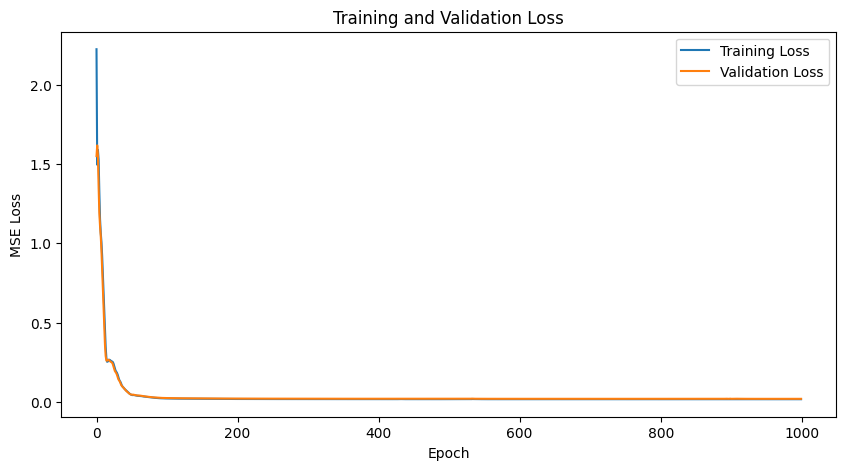

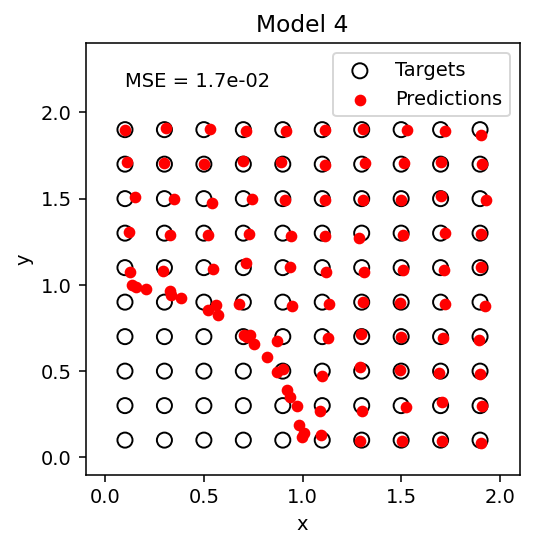

Epoch    0/1000: Train Loss = 2.6804, Validation Loss = 2.8504
Epoch   40/1000: Train Loss = 0.3415, Validation Loss = 0.8446
Epoch   80/1000: Train Loss = 0.5532, Validation Loss = 0.4691
Epoch  120/1000: Train Loss = 0.3397, Validation Loss = 0.3425
Epoch  160/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  200/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  240/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  280/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  320/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  360/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  400/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  440/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  480/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  520/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  560/1000: Train Loss = 0.3395, Validation Loss = 0.3426
Epoch  600/1000: Train Loss = 0.3395, Validation Loss =

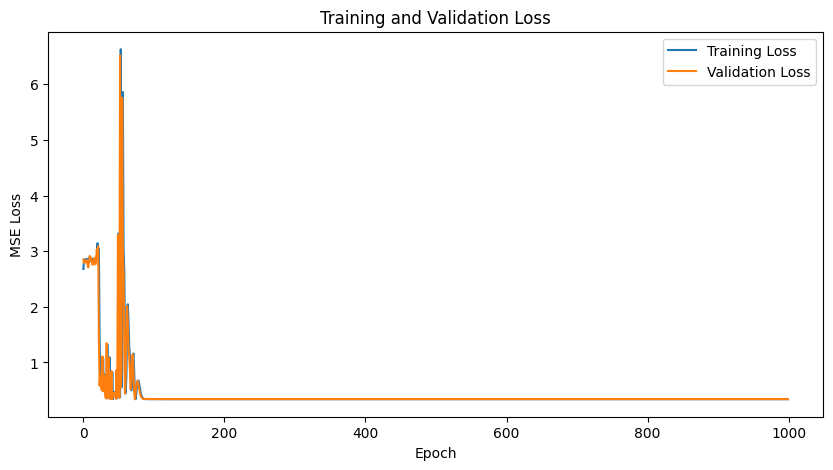

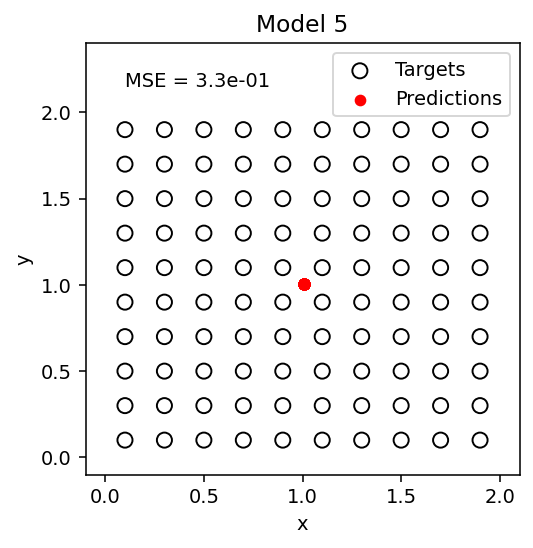

Epoch    0/300: Train Loss = 2.4209, Validation Loss = 2.4439
Epoch   12/300: Train Loss = 2.1337, Validation Loss = 2.1677
Epoch   24/300: Train Loss = 1.9155, Validation Loss = 1.9580
Epoch   36/300: Train Loss = 1.7620, Validation Loss = 1.8101
Epoch   48/300: Train Loss = 1.6569, Validation Loss = 1.7079
Epoch   60/300: Train Loss = 1.5812, Validation Loss = 1.6333
Epoch   72/300: Train Loss = 1.5192, Validation Loss = 1.5718
Epoch   84/300: Train Loss = 1.4634, Validation Loss = 1.5162
Epoch   96/300: Train Loss = 1.4113, Validation Loss = 1.4644
Epoch  108/300: Train Loss = 1.3624, Validation Loss = 1.4158
Epoch  120/300: Train Loss = 1.3157, Validation Loss = 1.3692
Epoch  132/300: Train Loss = 1.2704, Validation Loss = 1.3239
Epoch  144/300: Train Loss = 1.2264, Validation Loss = 1.2800
Epoch  156/300: Train Loss = 1.1829, Validation Loss = 1.2364
Epoch  168/300: Train Loss = 1.1385, Validation Loss = 1.1918
Epoch  180/300: Train Loss = 1.0926, Validation Loss = 1.1456
Epoch  1

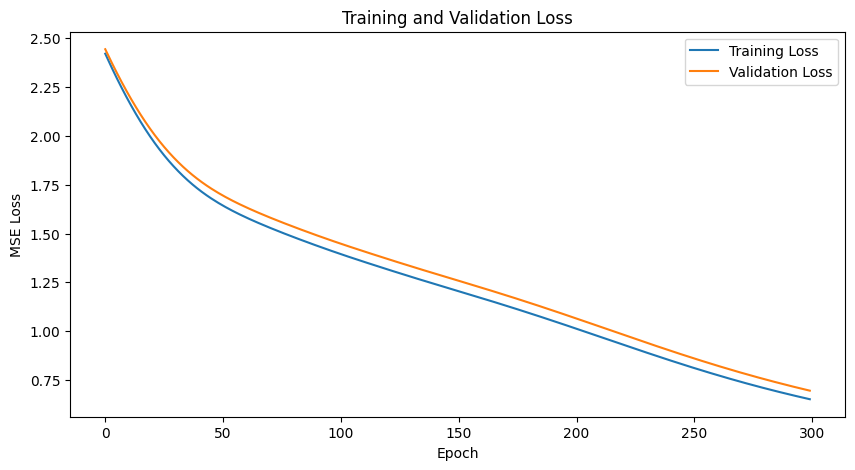

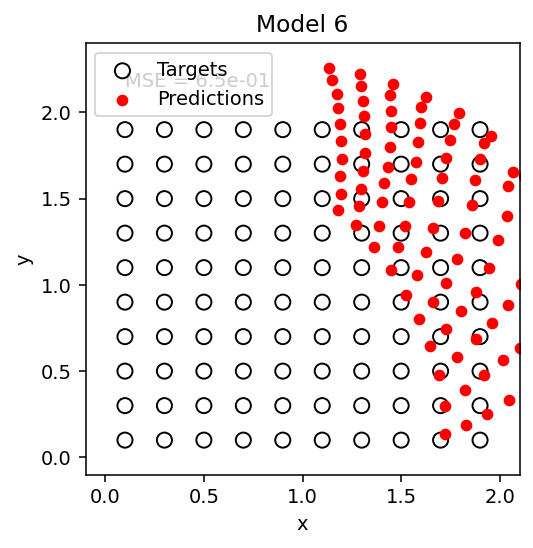

In [74]:
# YOUR CODE GOES HERE
model4 = InverseArm(hidden_layer_sizes=[48, 48], max_angle = np.pi/2)
model4 = train(model4, X_train, X_val, epochs = 1000, lr = 0.01, gamma = 0.995, create_plot = True)
plot_predictions(model4, title = "Model 4")

model5 = InverseArm(hidden_layer_sizes = [48,48], max_angle = None)
model5 = train(model5, X_train, X_val, epochs = 1000, lr = 1, gamma = 1, create_plot = True)
plot_predictions(model5, title="Model 5")

model6 = InverseArm(hidden_layer_sizes = [48,48], max_angle = 2)
model6 = train(model6, X_train, X_val, epochs = 300, lr = 0.0001, gamma = 1, create_plot = True)
plot_predictions(model6, title = "Model 6")

## Prompts

None of these 3 models should have great performance.
Describe what went wrong in each case.

Model 4 is performing poorly because the max_angle parameter is incorrectly set. Since max_angle is set to pi/2, the predictions for the lower half of the x and y coordinates are incorrect.

Model 5 is underperforming due to an excessively high learning rate of 1. This causes the model to oscillate around the global minimum without converging.

Model 6 is underfitting because the number of epochs is too low for the model to reach the global optimum. As a result, the loss function does not fully converge, leading to poor performance.